In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This is Kaggle's 'Credit Card Fraud Detection Dataset 2023' found here:

https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/data

"Data Source: The dataset was collected from credit card transactions made by European cardholders in 2023, with sensitive information removed to ensure privacy and compliance with ethical guidelines."

Columns 'V1', 'V2' . . . 'V28' are 'anonymized' information related to time, location etc. of credit card purchase.
I'm curious how time, location information can be standardized this way, but for the purpose of this experiment, I don't think it really matters? 

In [191]:
data = pd.read_csv('creditcard_2023.csv')

In [192]:
data.tail()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
568625,568625,-0.833437,0.061886,-0.899794,0.904227,-1.002401,0.481454,-0.370393,0.189694,-0.938153,...,0.167503,0.419731,1.288249,-0.900861,0.560661,-0.006018,3.308968,0.081564,4394.16,1
568626,568626,-0.670459,-0.202896,-0.068129,-0.267328,-0.133660,0.237148,-0.016935,-0.147733,0.483894,...,0.031874,0.388161,-0.154257,-0.846452,-0.153443,1.961398,-1.528642,1.704306,4653.40,1
568627,568627,-0.311997,-0.004095,0.137526,-0.035893,-0.042291,0.121098,-0.070958,-0.019997,-0.122048,...,0.140788,0.536523,-0.211100,-0.448909,0.540073,-0.755836,-0.487540,-0.268741,23572.85,1
568628,568628,0.636871,-0.516970,-0.300889,-0.144480,0.131042,-0.294148,0.580568,-0.207723,0.893527,...,-0.060381,-0.195609,-0.175488,-0.554643,-0.099669,-1.434931,-0.159269,-0.076251,10160.83,1
568629,568629,-0.795144,0.433236,-0.649140,0.374732,-0.244976,-0.603493,-0.347613,-0.340814,0.253971,...,0.534853,-0.291514,0.157303,0.931030,-0.349423,-1.090974,-1.575113,0.722936,21493.92,1


This is a classification problem, with the targets 1, a fraudulent transaction, or 0. We'll need to implement a supervised classification model to determine if a given transaction is fraudulent or not.

In [7]:
data['Class'].value_counts() # target classes are 1:1

0    284315
1    284315
Name: Class, dtype: int64

This table is organized so that the first half are class 0, the second half are 1. This is convenient because target classes will do not require weights. 

I chose to take a random sample without replacement for analysis. I will fit and test the model with a sample, then later expand to the full data set.

In [193]:
sample = data.sample(frac=0.02, random_state=1, replace=False)

In [194]:
sample.shape

(11373, 31)

The patterns appear to be among the standardized V1 to V28 columns. 'Amount' seems to have no relationship with the target. One might expect more expensive purchases to be fraudulent, but that's not necessarily the case here.

Text(0.5, 0.98, 'Distribution of target class')

<Figure size 640x480 with 0 Axes>

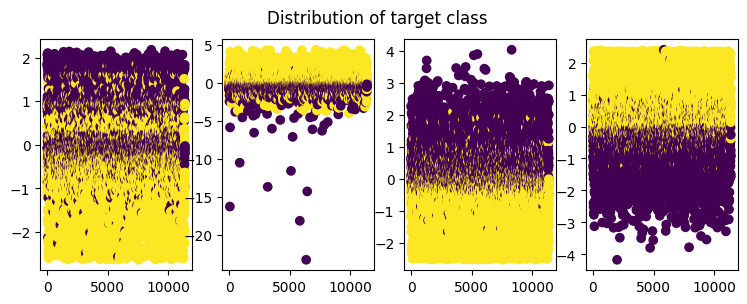

In [195]:
fig = plt.figure()
fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=False)
axs[0].scatter(y=sample['V1'], x=range(sample.shape[0]), c=sample.Class)
axs[1].scatter(y=sample['V2'], x=range(sample.shape[0]), c=sample.Class)
axs[2].scatter(y=sample['V3'], x=range(sample.shape[0]), c=sample.Class)
axs[3].scatter(y=sample['V4'], x=range(sample.shape[0]), c=sample.Class)
fig.suptitle('Distribution of target class')

My thinking is:
1. \* Let's drop id and standardize 'Amount' (we will do this in the pipeline) this way all features are standardized (mean 0, std 1).

2. It could be that columns 'V1' to 'V28' are PCA features, however there's no mention of this on Kaggle.

3. ** Since all of this data will be standardized in the pipeline, I try to PCA the whole thing and gridsearch the optimal number of components.

4. SVC with 'rbf' kernel because between 'V1' to 'V28' there are a variety of different patterns related to the targets. So I'll let rbf work its high dimensional magic.

5. 'Recall' will be used to score the model, high recall implies low false-negatives, which is what we want to achieve.

\* I considered dropping 'Amount', however after some testing, it's inclusion tends to increase recall score by 0.01

** PCA did nothing to improve fitting time or recall. Seems it is only necessary where there are excess features.

I will try to models, Support Vector Classifier and Logistic Regression.

# SVC Approach

In [196]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
#from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split

In [197]:

# This will standardize 'Amount' and drop 'id'

trns = ColumnTransformer([
                            ('amounts_scaled', StandardScaler(), ['Amount']),
                            ('drop_id',  'drop',  ['id'])
                         ], 
                             remainder = 'passthrough',
                             n_jobs=-1,
                             verbose_feature_names_out = False)

In [198]:
#pipe = make_pipeline(trns, PCA(), SVC())
SVC_pipe = make_pipeline(trns, SVC())

In [199]:
SVC_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('amounts_scaled',
                                                  StandardScaler(),
                                                  ['Amount']),
                                                 ('drop_id', 'drop', ['id'])],
                                   verbose_feature_names_out=False)),
                ('svc', SVC())])

In [225]:
parameters = {'svc__C':[12,13,14,15,16,17,18],
              'svc__kernel':['rbf'],
              'svc__gamma':['auto']}
              #'pca__n_components':[15,16,17,18]}


In [226]:
X_train, X_test, y_train, y_test = train_test_split(sample.drop(columns=['Class']), 
                                                                sample['Class'],
                                                                random_state=1)

In [227]:
SVC_grid = GridSearchCV(estimator=SVC_pipe, param_grid=parameters, scoring='recall')

In [228]:
SVC_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('amounts_scaled',
                                                                         StandardScaler(),
                                                                         ['Amount']),
                                                                        ('drop_id',
                                                                         'drop',
                                                                         ['id'])],
                                                          verbose_feature_names_out=False)),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [12, 13, 14, 15, 16, 17, 18],
                         'svc__gamma': ['auto'], 'svc__kernel': ['rbf']},
             scoring='recall')

In [233]:
SVC_grid.best_params_, grid.best_score_

({'svc__C': 18, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'},
 0.9405862266671562)

In [247]:
print('SVC Recall :', round(SVC_grid.best_estimator_.score(X_test, y_test) * 100, 2), '%')

SVC Recall : 99.33 %


In [248]:
print('SVC Score time :', SVC_grid.cv_results_['mean_score_time'].mean())

SVC Score time : 0.07674683843340192


Both recall and accuracy are high in this case. After testing the parameters for some time, I increased the score gradually to something around 99%

(AM I DOING THIS RIGHT?)

# Logistic Regression Approach

In [206]:
from sklearn.linear_model import LogisticRegression

In [207]:
logistic_pipe = make_pipeline(trns, LogisticRegression())

In [208]:
logistic_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('amounts_scaled',
                                                  StandardScaler(),
                                                  ['Amount']),
                                                 ('drop_id', 'drop', ['id'])],
                                   verbose_feature_names_out=False)),
                ('logisticregression', LogisticRegression())])

In [241]:
parameters = {'logisticregression__max_iter':[100],
              'logisticregression__penalty':['l2'],
              'logisticregression__C':[1,2,3,4,5],
              'logisticregression__solver':['liblinear','newton-cg','newton-cholesky','lbfgs']}

In [242]:
log_grid = GridSearchCV(estimator=logistic_pipe, param_grid=parameters, scoring='recall')

In [243]:
log_grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('amounts_scaled',
                                                                         StandardScaler(),
                                                                         ['Amount']),
                                                                        ('drop_id',
                                                                         'drop',
                                                                         ['id'])],
                                                          verbose_feature_names_out=False)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [1, 2, 3, 4, 5],
                         'logisticregression__max_iter': [100],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['liblinear',
                                                        'newton-cg',
                                                        'newton-cholesky',
                                                        'lbfgs']},
             scoring='recall')

In [244]:
log_grid.best_params_, grid.best_score_

({'logisticregression__C': 3,
  'logisticregression__max_iter': 100,
  'logisticregression__penalty': 'l2',
  'logisticregression__solver': 'newton-cg'},
 0.9405862266671562)

In [246]:
print('Logit Recall :', round(log_grid.best_estimator_.score(X_test, y_test) * 100, 2), '%')

Recall : 96.55 %


In [245]:
print('Logit Score Time :', log_grid.cv_results_['mean_score_time'].mean())

Time : 0.02029804706573487


The Logitistic model is quite a bit faster than the SVC model, both could be faster with principal components but it will cost score.